In [21]:
import requests
import io
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split,GridSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, accuracy_score, recall_score, precision_score, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier
from statsmodels.tools.tools import add_constant
from os import listdir
from os.path import isfile, join

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('APPL_formatted.csv', index_col = 0)
df.dropna(inplace = True)

In [3]:
df.index = pd.to_datetime(df.index)

In [4]:
df2 = df.drop(['sma252','sma50','ema22zone','ema252zone', 'ema50', 'BBU_5_2.0', 'ema7zone', 'sma22', 'ema50zone', 'BBL_5_2.0', 'BBM_5_2.0', 'ema22', 'sma7','ema252'],axis = 1)

In [5]:
corrs = df2.corr().stack().reset_index()
corrs.columns = ['1','2','R2']
temp = corrs[(corrs.R2 > .8) & (corrs.R2 < .999)].sort_values('R2', ascending = False).reset_index(drop = True)
correlations = temp[temp.index % 2 == 0]

In [6]:
correlations

,1,2,R2


In [7]:
X = df2.shift(1).dropna()
y = df2['adjustedclose'].iloc[1:]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(8073, 20) (2019, 20)
(8073,) (2019,)


In [9]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [10]:
X_train_scaled.set_index(y_train.index, inplace = True)

In [11]:
from statsmodels.regression.linear_model import OLS

In [32]:
exog_train = add_constant(X_train_scaled)
exog_test = add_constant(X_test_scaled)

In [33]:
lin_reg = OLS(y_train, exog_train, hasconst = True)

In [34]:
results = lin_reg.fit()

In [35]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          adjustedclose   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.768e+05
Date:                Wed, 12 Jan 2022   Prob (F-statistic):               0.00
Time:                        13:33:04   Log-Likelihood:                -6701.4
No. Observations:                8073   AIC:                         1.344e+04
Df Residuals:                    8052   BIC:                         1.359e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     12.6118      0.006   2039.187      0.000      12.600      12.624
low                       11.8378      0.772     15.333      0.000      10.324      13.351
open                      -8.9406      0.829    -10.782      0.000     -10.566      -7.315
volume                    -0.0007      0.007     -0.102      0.919      -0.014       0.013
high                       8.9917      0.910      9.876      0.000       7.207      10.776
close                    -13.4055      0.843    -15.908      0.000     -15.057     -11.754
adjustedclose             27.4735      0.229    120.231      0.000      27.026      27.921
rsi                       -0.0027      0.010     -0.264      0.792      -0.022       0.017
BBB_5_2.0                  0.0031      0.007      0.431      0.666      -0.011       0.017
BBP_5_2.0                  0.0045      0.010      0.465      0.642      -0.014       0.024
ema7                       1.3762      0.543      2.534      0.011       0.312       2.441
day_direction              0.0072      0.008      0.879      0.380      -0.009       0.023
golden_crossover_short     0.0075      0.006      1.204      0.229      -0.005       0.020
death_crossover_short      0.0004      0.006      0.067      0.947      -0.012       0.013
golden_crossover_long      0.0014      0.006      0.232      0.816      -0.011       0.014
death_crossover_long       0.0018      0.006      0.282      0.778      -0.010       0.014
RSI_overbought_cross       0.0008      0.007      0.114      0.910      -0.013       0.015
RSI_oversold_cross        -0.0085      0.007     -1.181      0.238      -0.023       0.006
RSI_overbought             0.0118      0.009      1.349      0.177      -0.005       0.029
RSI_oversold               0.0023      0.008      0.285      0.776      -0.013       0.018
momentum                   0.0080      0.011      0.714      0.476      -0.014       0.030
==============================================================================
Omnibus:                     2898.352   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1308591.470
Skew:                           0.188   Prob(JB):                         0.00
Kurtosis:                      65.371   Cond. No.                         560.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
y_hat = lin_reg.predict(results.params, exog_test)

In [38]:
resids = y_hat - y_test

In [39]:
resids.sort_index(inplace=True)

<AxesSubplot:xlabel='date'>

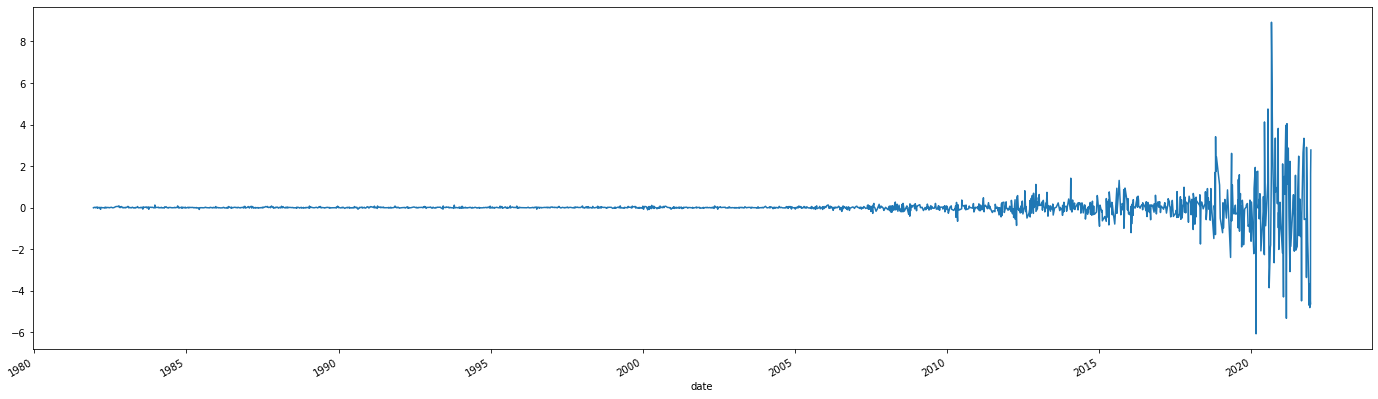

In [40]:
resids.plot(figsize = (24,7))